In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
import pickle

from skimage import measure, segmentation, feature
from vis_utils import load_volume, VolumeVisualizer, ColorMapVisualizer
from scipy.ndimage import zoom
from skimage.morphology import skeletonize, skeletonize_3d, binary_dilation
from skimage import filters, morphology
from scipy.ndimage.filters import convolve, correlate
from scipy import signal
from skimage.filters import frangi, sato
from skimage.draw import line_nd
from PIL import Image
from queue import PriorityQueue

from sklearn.decomposition import PCA

In [2]:
class Node:
    def __init__(self, coords):
        self.coords = coords
        self.edges = []
        self.data = {}
            
    def add_edge(self, edge):
        self.edges.append(edge)
        
    def get_neighbours(self):
        return [e.node_a if e.node_a.coords != self.coords else e.node_b for e in self.edges]
    
    def copy_without_edges(self):
        copied_node = Node(self.coords)
        copied_node.data = self.data
        return copied_node
    
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __hash__(self):
        return hash(self.coords)
    
    def __repr__(self):
        return f'Node {str(self.coords)}'
       
        
class Edge:
    def __init__(self, node_a, node_b):
        self.node_a = node_a
        self.node_b = node_b
        self.data = {}
        
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __repr__(self):
        return f'Edge {self.node_a.coords} -> {self.node_b.coords}'

    
class DAG:
    def __init__(self, root):
        self.root = root
        self.nodes = get_nodes_with_dfs(root)
        self.edges = get_edges_with_dfs(root)
        

def save_dag(dag, filename):
    with open(filename, 'wb') as output:
        pickle.dump(dag, output)
        

def load_dag(filename):
    with open(filename, 'rb') as input_:
        dag = pickle.load(input_)
        return dag

In [3]:
source_dir = './data/P12/'
dag = load_dag(f'{source_dir}/dag-with-stats.pkl')
thiccness_map = np.pad(np.load(source_dir + 'thiccness-map.npy'), 1)

## visualisation helper functions

In [4]:
def visualize_addition(base, base_with_addition):
    base = (base.copy() > 0).astype(np.uint8)
    addition = (base_with_addition > 0).astype(np.uint8)
    addition[base == 1] = 0
    ColorMapVisualizer(base + addition * 4).visualize()
    
def visualize_lsd(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize()
    
def visualize_gradient(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize(gradient=True)
    
def visualize_mask_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8), binary=True).visualize()
    
def visualize_mask_non_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8) * 255, binary=False).visualize()
    
def visualize_skeleton(mask, visualize_mask=True, visualize_both_versions=False):
    skeleton = skeletonize((mask > 0).astype(np.uint8))
    if not visualize_mask or visualize_both_versions:
        VolumeVisualizer(skeleton, binary=True).visualize()
    if visualize_mask or visualize_both_versions:
        skeleton = skeleton.astype(np.uint8) * 4
        mask = (mask > 0).astype(np.uint8) * 3
        mask[skeleton != 0] = 0
        ColorMapVisualizer(skeleton + mask).visualize()

def visualize_ultimate(lsd, base_mask):
    visualize_lsd(lsd)
    visualize_mask_non_bin(lsd)
    visualize_addition(base_mask, lsd)
    visualize_skeleton(lsd, visualize_mask=True)

## DAG visualization

In [5]:
def spherical_kernel(outer_radius, thickness=1, filled=True):    
    outer_sphere = morphology.ball(radius=outer_radius)
    if filled:
        return outer_sphere
    
    thickness = min(thickness, outer_radius)
    
    inner_radius = outer_radius - thickness
    inner_sphere = morphology.ball(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    outer_sphere[begin:end, begin:end, begin:end] -= inner_sphere
    return outer_sphere


def print_kernels(image, nodes, value):
    image = image.copy()
    max_kernel_radius = int(max([node['thiccness'] for node in nodes]))
    kernels = [spherical_kernel(radius) for radius in range(max_kernel_radius + 1)]
    
    padded_image = np.pad(image, max_kernel_radius)
    kernels_image = np.zeros(padded_image.shape)
    
    for node in nodes:
        x, y, z = (coord + max_kernel_radius for coord in node.coords)
        kernel_radius = int(node['thiccness'])
        kernel = kernels[kernel_radius]
        
        mask_slice = kernels_image[
            x-kernel_radius:x+kernel_radius + 1,
            y-kernel_radius:y+kernel_radius + 1,
            z-kernel_radius:z+kernel_radius + 1
        ]
        
        mask_slice[:] = np.logical_or(mask_slice, kernel)
            
    kernels_image = kernels_image[
        max_kernel_radius:-max_kernel_radius,
        max_kernel_radius:-max_kernel_radius,
        max_kernel_radius:-max_kernel_radius
    ]
    
    image[kernels_image == 1] = value
    return image


def draw_nodes(image, nodes, value=2):
    nodes_image = print_kernels(image, nodes, value)
    return nodes_image

    
def draw_edges(image, edges, value='mean_thiccness', interpolate=True):
    image = image.copy()

    for i, edge in enumerate(edges):
        if type(value) == str:
            fill_value = edge[value]
        else:
            fill_value = value
        
        if interpolate:
            image[line_nd(edge.node_a.coords, edge.node_b.coords)] = fill_value
        else:
            for v in edge['voxels']:
                image[tuple(v)] = fill_value
        
    return image


def draw_central_line(image, dag):
    image_with_edges = draw_edges(image, dag.edges, value=1, interpolate=False)
    for n in dag.nodes:
        for v in n['voxels']:
            image_with_edges[tuple(v)] = 1
        
    return image_with_edges

In [6]:
visualization = np.zeros(thiccness_map.shape)
visualization = draw_central_line(visualization, dag)
# visualize_mask_bin(visualization)
kidney_tree = visualization

## finding main renal surface

In [7]:
def add_voxels_pca_mapping(dag, central_line_image):
    central_line_coords = np.argwhere(central_line_image > 0)
    pca = PCA(n_components=2)
    pca.fit(central_line_coords)
    
    for n in dag.nodes:
        n['voxels2d'] = pca.transform(n['voxels'])
    
    for e in dag.edges:
        e['voxels2d'] = pca.transform(e['voxels'])    

In [8]:
add_voxels_pca_mapping(dag, kidney_tree)
dag.root['voxels']

array([[395,  79, 279]])

In [9]:
dag.root['voxels2d']

array([[  6.0458952 , 199.50364912]])

In [10]:
def add_symmetry_divergence_angles(dag):
    def calculate_vectors_relative_angle(v1, v2):
        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)
        cosine = np.dot(v1,v2)
        return np.arccos(cosine)
    
    root_2d_reference = np.mean(dag.root['voxels2d'], axis=0)
    symmetry_vector = np.zeros(2)
    symmetry_vector[1] = root_2d_reference[1] if root_2d_reference[1] < 0 else -root_2d_reference[1]
    
    for e in dag.edges:
        edge_centroid_2d = np.mean(e['voxels2d'], axis=0)
        edge_vector = edge_centroid_2d - root_2d_reference
        e['symmetry_divergence_angle'] = calculate_vectors_relative_angle(symmetry_vector, edge_vector)
        
    for n in dag.nodes:
        if n == dag.root:
            n['symmetry_divergence_angle'] = 0
            continue
    
        node_centroid_2d = np.mean(n['voxels2d'], axis=0)
        node_vector = node_centroid_2d - root_2d_reference
        n['symmetry_divergence_angle'] = calculate_vectors_relative_angle(symmetry_vector, node_vector)

In [11]:
add_symmetry_divergence_angles(dag)

In [12]:
visualization = np.zeros(thiccness_map.shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='symmetry_divergence_angle')
visualize_gradient(np.ceil(visualization * 100 / np.pi))

## scaling segment distance

In [27]:
def calculate_scaled_distance(dist, divergence_angle, x_scalar=1.0):
    return dist * np.cos(x_scalar * divergence_angle)


def recursive_add_root_path_distances(node, distance, x_scalar):
    node['distance_from_root'] = distance
    node['scaled_distance_from_root'] = calculate_scaled_distance(
        distance,
        node['symmetry_divergence_angle'],
        x_scalar
    )
    
    for e in node.edges:
        e['distance_from_root'] = node['distance_from_root']
        e['scaled_distance_from_root'] = node['scaled_distance_from_root']        
        new_distance = distance + e['length']
        recursive_add_root_path_distances(e.node_b, new_distance, x_scalar)
        
def add_root_path_distances(dag, x_scalar=1.0):
    recursive_add_root_path_distances(dag.root, 0., x_scalar)
    
    
def add_root_absolute_distances(dag, x_scalar=1.0):
    for n in dag.nodes:
        dist = np.linalg.norm(n['centroid'] - dag.root['centroid'])
        n['absolute_distance'] = dist
        n['scaled_absolute_distance'] = calculate_scaled_distance(
            dist,
            n['symmetry_divergence_angle'],
            x_scalar
        )
        
    for e in dag.edges:
        e['absolute_distance'] = e.node_a['absolute_distance']
        e['scaled_absolute_distance'] = e.node_a['scaled_absolute_distance']

In [36]:
add_root_path_distances(dag, 0.3)
add_root_absolute_distances(dag, 1.0)

In [37]:
visualization = np.zeros(thiccness_map.shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='scaled_distance_from_root')
visualize_gradient(np.ceil(visualization / visualization.max() * 254))

## discovering generations

In [38]:
def discover_generations(dag, max_thiccness_difference=0.7, max_generation_number=np.inf):
    queue = PriorityQueue()
    first_edge = dag.root.edges[0]
    counter = 0
    first_entry = ((-first_edge['mean_thiccness'], counter), first_edge) 
    queue.put(first_entry)
    
    generation_number = 1
    generation_thiccness = first_edge['mean_thiccness']
    
    while not queue.empty():
        _, edge = queue.get()
        
        if edge['mean_thiccness'] < (max_thiccness_difference * generation_thiccness) and generation_number > 0:
            generation_thiccness = edge['mean_thiccness']
            generation_number += 1
            
            if generation_number > max_generation_number:
                generation_number = 0
            
        edge['generation_number'] = generation_number
        
        for e in edge.node_b.edges:
            counter += 1
            entry = ((-e['mean_thiccness'], counter), e)
            queue.put(entry)
            
            
def discover_generations2(dag, max_thiccness_difference=0.7, max_generation_number=np.inf):
    queue = PriorityQueue()
    first_edge = dag.root.edges[0]
    counter = 0
    first_entry = ((-first_edge['scaled_distance_from_root'], counter), first_edge) 
    queue.put(first_entry)
    
    generation_number = 1
    generation_thiccness = first_edge['mean_thiccness']
    
    while not queue.empty():
        _, edge = queue.get()
        
        if edge['mean_thiccness'] < (max_thiccness_difference * generation_thiccness) and generation_number > 0:
            generation_thiccness = edge['mean_thiccness']
            generation_number += 1
            
            if generation_number > max_generation_number:
                generation_number = 0
            
        edge['generation_number'] = generation_number
        
        for e in edge.node_b.edges:
            counter += 1
            entry = ((-e['scaled_distance_from_root'], counter), e)
            queue.put(entry)
            

def discover_generations_by_distance(dag):
    queue = PriorityQueue()
    first_edge = dag.root.edges[0]
    counter = 0
    first_entry = ((-first_edge['mean_thiccness'], counter), first_edge) 
    queue.put(first_entry)
    
    generation_number = 1
    generation_thiccness = first_edge['mean_thiccness']
    
    while not queue.empty():
        _, edge = queue.get()
        
        if edge['mean_thiccness'] < (max_thiccness_difference * generation_thiccness) and generation_number > 0:
            generation_thiccness = edge['mean_thiccness']
            generation_number += 1
            
            if generation_number > max_generation_number:
                generation_number = 0
            
        edge['generation_number'] = generation_number
        
        for e in edge.node_b.edges:
            counter += 1
            entry = ((-e['mean_thiccness'], counter), e)
            queue.put(entry)

In [39]:
discover_generations2(dag, 0.8, max_generation_number=5)

In [40]:
visualization = np.zeros(thiccness_map.shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='generation_number')
visualize_lsd(visualization)

In [19]:
visualize_mask_non_bin(thiccness_map > 0)

In [41]:
dag.edges[0].__dict__

{'node_a': Node (395, 79, 279),
 'node_b': Node (382, 90, 282),
 'data': {'voxels': [(394, 79, 280),
   (393, 80, 281),
   (392, 81, 281),
   (392, 82, 280),
   (391, 83, 280),
   (390, 84, 280),
   (389, 85, 280),
   (388, 86, 280),
   (387, 87, 280),
   (387, 88, 280),
   (386, 89, 280),
   (385, 89, 280),
   (384, 90, 280)],
  'thiccness_list': array([12., 12., 12., 12., 12., 12., 11., 11., 11., 11., 11., 11., 11.]),
  'mean_thiccness': 11.461538461538462,
  'length': 18.641729234073843,
  'start_direction': array([-0.71929703,  0.37296883,  0.58609388]),
  'end_direction': array([-0.84384828,  0.33151183,  0.42192414]),
  'relative_angle': None,
  'tortuosity': 1.086591919985184,
  'centroid': array([389.07692308,  84.84615385, 280.15384615]),
  'voxels2d': array([[  6.94937009, 198.45295575],
         [  7.88279086, 197.68568387],
         [  7.82088897, 197.01498486],
         [  6.85551218, 197.39497923],
         [  6.79361028, 196.72428022],
         [  6.73170838, 196.0535812

## generation discovery based on parent only

In [66]:
def parent_generation_discovery(edge, same_generation_lambda, parent_edge=None, max_generation=np.inf):
    if parent_edge is None:
        edge['generation'] = 1
        
    else:
        if same_generation_lambda(parent_edge, edge):
            edge['generation'] = parent_edge['generation']
            
        else:
            edge['generation'] = parent_edge['generation'] + 1
            
    if edge['generation'] > max_generation:
        edge['generation'] = max_generation + 1
            
    for e in edge.node_b.edges:
        parent_generation_discovery(e, same_generation_lambda, edge, max_generation)
        
        
def angle_lambda(max_valid_angle, max_thiccness_diff):
    def wrapped(a, b):
        return (
            b['relative_angle'] < max_valid_angle and 
            b['mean_thiccness'] > max_thiccness_diff * a['mean_thiccness']
        )
    
    return wrapped

In [119]:
parent_generation_discovery(
    dag.edges[0],
    angle_lambda(max_valid_angle=np.pi / 6., max_thiccness_diff=0.7),
    max_generation=8
)

In [72]:
visualization = np.zeros(thiccness_map.shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='generation')
visualize_lsd(visualization)

In [83]:
def distance_based_generation_postprocessing(dag, max_generation, max_distance_deviation=1.2):
    counter = 0
    
    for generation_number in range(1, max_generation + 1):
        generation_edges = [e for e in dag.edges if e['generation'] == generation_number]
        if len(generation_edges) == 0:
            break
                
        mean_dist = np.mean([e['scaled_distance_from_root'] for e in generation_edges])
        invalid_edges = [e for e in generation_edges
                         if e['scaled_distance_from_root'] > (max_distance_deviation * mean_dist)]
        
        for e in invalid_edges:
            e['generation'] += 1
            counter += 1
            
    print(f'changed {counter} edges')

In [122]:
distance_based_generation_postprocessing(dag, 7, max_distance_deviation=1.5)

changed 2 edges


In [88]:
visualization = np.zeros(thiccness_map.shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='generation')
visualize_lsd(visualization)

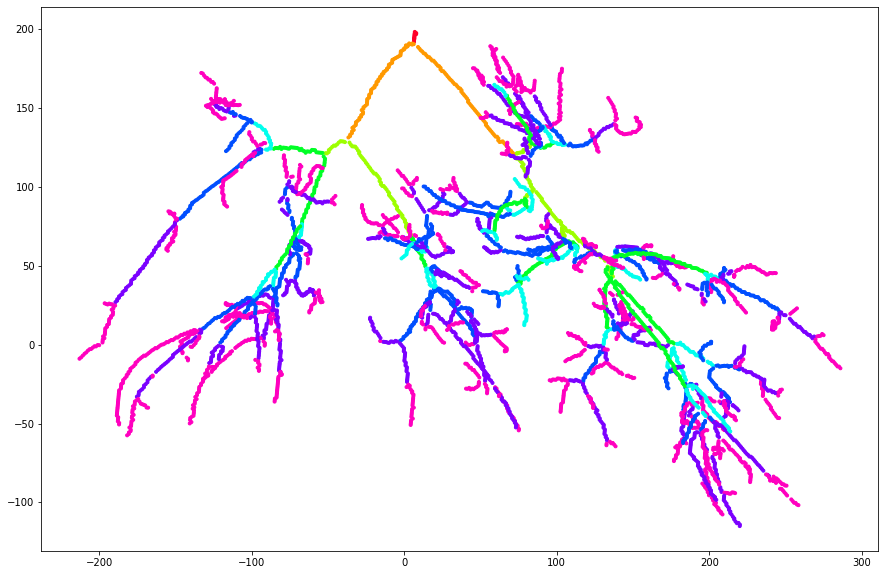

In [123]:
points = np.concatenate([e['voxels2d'] for e in dag.edges])
colors = np.concatenate([np.full(len(e['voxels2d']), fill_value=e['generation']) for e in dag.edges])

max_gen = 8

points = points[colors <= max_gen]
colors = colors[colors <= max_gen]

plt.figure(figsize=(15, 10))
plt.scatter(points[:, 0], points[:, 1], c=colors, s=9, cmap='gist_rainbow')

# 'Pastel1', 'Pastel2', 'Paired', 'Accent',
#                         'Dark2', 'Set1', 'Set2', 'Set3',
#                         'tab10', 'tab20', 'tab20b', 'tab20c'